In [2]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING  --disable_caching ndw_interference_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s ndw_interference_Scene"

In [ ]:
class SoundSources(Mobject):
    def __init__(self, center_A = np.array([-2.5, -1.5, 0]), center_B = np.array([2.5, -1.5, 0]), c = 1, **kwargs):
        super().__init__(**kwargs)
        speaker_left = ImageMobject("../external_media/lautsprecher_black.png").scale(0.25).move_to(center_A)
        speaker_right = ImageMobject("../external_media/lautsprecher_black.png").scale(0.25).move_to(center_B)
        self.add(speaker_left, speaker_right)


class Crowd(Mobject):
    def __init__(self):
        super().__init__(**kwargs)

Manim Community v0.18.1

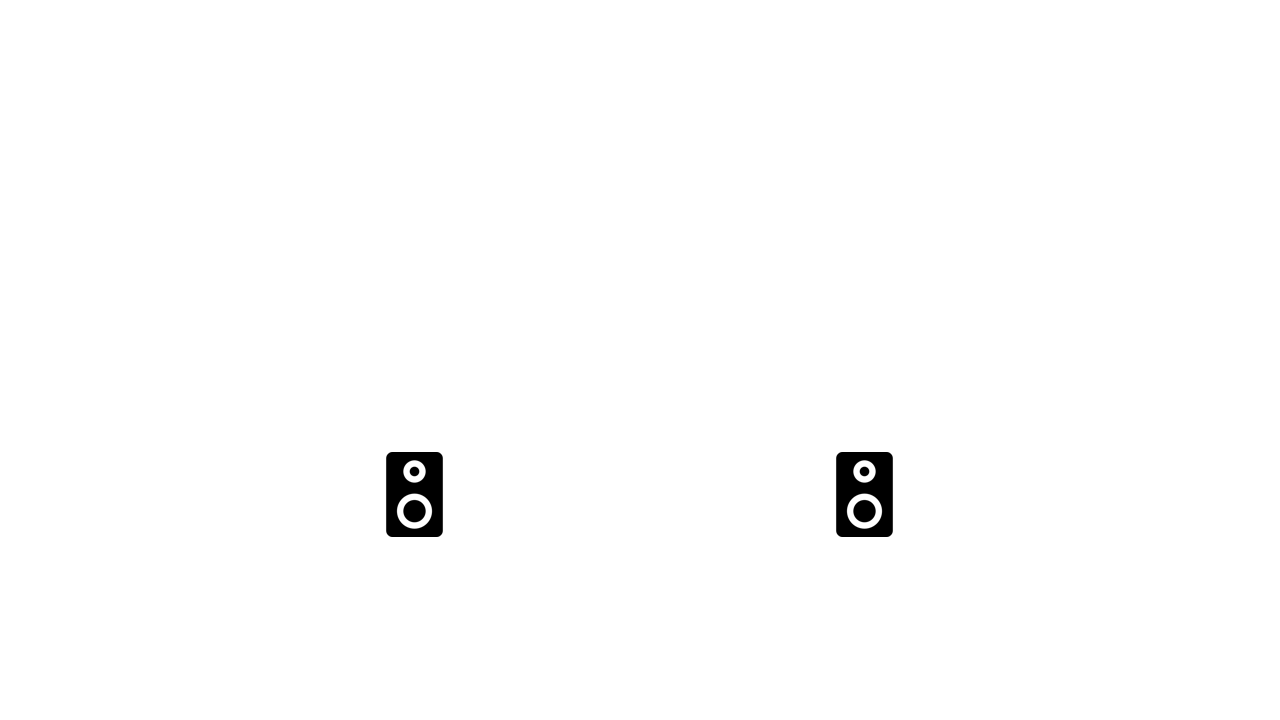

In [13]:
%%manim -qm --fps 60 $video_scene


class ndw_interference_Scene(Scene):
    def construct(self):
        self.camera.background_color = WHITE

        sound_source = SoundSources()
        self.add(sound_source)